# Title
Madeline M. Warndorf 
Graduate Student, EMSE Dept.
George Washington University
Washington, D.C.
mwarndorf65@gwu.edu

## General Analysis of Dataset and Preprocessing
### Importing Cleaned Final Dataset

In [2]:
import pandas as pd
from sklearn.utils import shuffle

#Importing Data as Pandas Dataframe
fars_file = "MLEMSE6992/fulldataset1516.csv"
fars_df = pd.read_csv(fars_file)

#print(fars_df.head())
fars_df = shuffle(fars_df)


#Casenum and vehnum were dropped because those were assigned by the police after the accident.
d_col = ['statenum','day','month','year','landuse','age','vfatcount','numoccs','modelyr']
t_col = ['cellphone_use']

### Determining if Dataset Needs to Be Undersampled

In [3]:
#Determine if there is a need to undersample
celluse = fars_df[fars_df["cellphone_use"] == 1]
no_celluse = fars_df[fars_df["cellphone_use"] == 0]
print("The number of accidents involving cellphones: {}".format(len(celluse)))
print("The number of accidents that did not involve cellphones: {}".format(len(no_celluse)))

total_accidents = len(celluse) + len(no_celluse)
print("The total number of accidents: %d" % total_accidents)
#Percentage of accidents involving cellphones
percentage = (len(celluse)/ total_accidents) * 100
print("The percentage of accidents that involved cellphones: {:.4}%".format(percentage))


The number of accidents involving cellphones: 832
The number of accidents that did not involve cellphones: 77701
The total number of accidents: 78533
The percentage of accidents that involved cellphones: 1.059%


### Creating New Dataframe with Undersampled Data
Storing new dataframe as a CSV to allow for this section of code not to be re-run and so the data isn't resampled to produce different answers down the line.

In [4]:
#Need to undersample
m = len(celluse)
selected_no_celluse = no_celluse.sample(m)


#Storing and Shuffling new dataset
undersampled_df = pd.concat([selected_no_celluse, celluse], ignore_index=True)
undersampled_df = shuffle(undersampled_df)

undersampled_df.to_csv("FARS_undersampled_df.csv", sep=",")


### Preprocessing the Data

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing

#Create data and target
undersampled_df = pd.read_csv("FARS_undersampled_df.csv", sep = ",")
undersampled_df = shuffle(undersampled_df)

far_data = undersampled_df[d_col]

far_dict_data = far_data.T.to_dict('dict').values()
vectorizer = DictVectorizer(sparse=False)
fardata = vectorizer.fit_transform(far_dict_data)

#PREPROCESSING EACH FEATURE TO HAVE ZERO MEAN AND UNIT VARIANCE
preprocessing.scale(fardata, copy=False)

fars_target_raw = undersampled_df['cellphone_use']
df_t = pd.get_dummies(fars_target_raw)
far_target = df_t[1]

fartarget = far_target.values

print(fardata)
print(fartarget)

[[-0.07339345  1.35087967  1.05690508 ... -1.0035252  -1.03702001
  -0.99759904]
 [ 0.77865332  1.69144788  1.05690508 ... -1.65199394 -1.03702001
  -0.99759904]
 [ 0.77865332 -0.91957512 -0.94615876 ...  0.47026737 -1.03702001
  -0.99759904]
 ...
 [ 0.66504708 -1.7142343   1.05690508 ... -1.35723542  0.70425274
  -0.99759904]
 [ 2.02832192 -1.60071156 -0.94615876 ... -0.17820136  2.44552549
  -0.99759904]
 [-1.1526527   1.12383419  1.05690508 ...  1.0597844  -1.03702001
   1.00240674]]
[0 1 0 ... 0 0 1]


## Deciding on Model
Finding best parameters for each type of model based on accuracy. 

In [ ]:
#Using GridSearch to determine the best Logistic Regression Model
#Setting parameters
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from warnings import filterwarnings
filterwarnings('ignore')

#Logistic Regression
param_grid = [{'C': [1e-2, 1e-1, 1e0, 1e1, 1e2], 'solver': ['lbfgs'],'max_iter': [100,1000,5000,10000]},
              {'C': [1e-2, 1e-1, 1e0, 1e1, 1e2], 'solver': ['liblinear'],'max_iter': [100,1000,5000]}]
lr = LogisticRegression()

me_grid = GridSearchCV(lr, param_grid, cv=10, scoring = 'accuracy')
me_grid.fit(fardata, fartarget)

print("__MaxEnt (Logistic Regression)__")
print("Best Score: %0.3f" % me_grid.best_score_)
print("Best Parameters set:")
print(me_grid.best_estimator_.get_params())

#SVC RBF
svc = svm.SVC()

param_gridSVC = [{'C': [1e0, 1e2, 1e5], 'kernel': ['rbf'], 'gamma': [0.1, 10]}]

svc_grid = GridSearchCV(svc, param_gridSVC, cv=10, scoring = 'accuracy')

svc_grid.fit(fardata, fartarget)


print("__Support Vector RBF Classifier__")
print("Best Score: %0.3f" % svc_grid.best_score_)
print("Best Parameters set:")
print(svc_grid.best_estimator_.get_params())

#LinearSVC
svcL = svm.LinearSVC()

param_gridSVCL = [{'C': [1e0, 1e2, 1e5], 'loss':['hinge','squared-hinge'], 'max_iter': [100, 1000, 5000, 10000]}]

svc_gridL = GridSearchCV(svcL, param_gridSVCL, cv=10, scoring = 'accuracy')

svc_gridL.fit(fardata, fartarget)


print("__Support Vector Linear Classifier__")
print("Best Score: %0.3f" % svc_gridL.best_score_)
print("Best Parameters set:")
print(svc_gridL.best_estimator_.get_params())

__MaxEnt (Logistic Regression)__
Best Score: 0.619
Best Parameters set:
{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


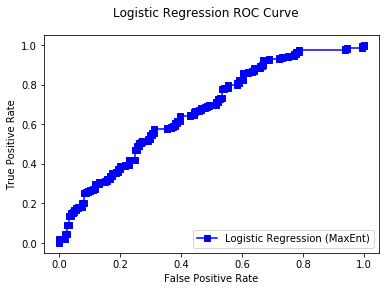

AUC for Logisitic Regression (MaxEnt): 0.673


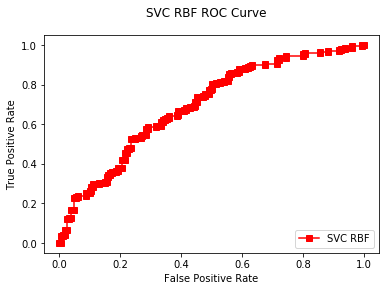

AUC for SVC RBF: 0.695


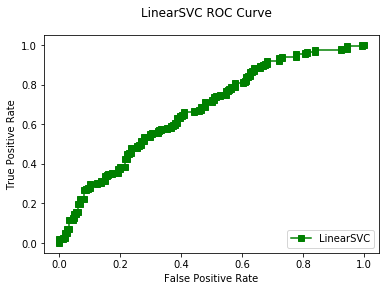

AUC for LinearSVC: 0.675


In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
#Setting test size to 20% of the data meaning it will be the last 333 entries.

#MaxEnt
log_reg = LogisticRegression(C = 0.1, solver = 'lbfgs', max_iter = 100)
log_reg.fit(fardata[333:],fartarget[333:])

lr_y_score = log_reg.predict_proba(fardata[:333])[:,1]

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],lr_y_score)
lr_roc_auc = metrics.auc(f_positive, t_positive)

fig = plt.figure()
fig.suptitle('Logistic Regression ROC Curve')
graph = fig.add_subplot(111)
graph.plot(f_positive, t_positive, c='blue', marker="s", label="Logistic Regression (MaxEnt)")
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("AUC for Logisitic Regression (MaxEnt): %.3f" % lr_roc_auc)

#SVC RBF
svc = svm.SVC(C = 1, kernel = 'rbf', gamma = 0.1, max_iter = -1)
svc.fit(fardata[333:],fartarget[333:])

svc_y_score = svc.decision_function(fardata[:333])

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],svc_y_score)
svc_roc_auc = metrics.auc(f_positive, t_positive)

fig = plt.figure()
fig.suptitle('SVC RBF ROC Curve')
graph = fig.add_subplot(111)
graph.plot(f_positive, t_positive, c='red', marker="s", label="SVC RBF")
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("AUC for SVC RBF: %.3f" % svc_roc_auc)


#Linear
linear_svc_classifier = svm.LinearSVC(C = 100, max_iter = 5000)
linear_svc_classifier.fit(fardata[333:],fartarget[333:])

y_score = linear_svc_classifier.decision_function(fardata[:333])

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],y_score)
roc_auc = metrics.auc(f_positive, t_positive)

fig = plt.figure()
fig.suptitle('LinearSVC ROC Curve')
graph = fig.add_subplot(111)
graph.plot(f_positive, t_positive, c='green', marker="s", label="LinearSVC")
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("AUC for LinearSVC: %.3f" % roc_auc)

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import metrics



linearsvc_scores = cross_val_score(linear_svc_classifier, fardata, fartarget, cv=10)
print("Average accuracy score for final classifier: %.3f" % np.mean(linearsvc_scores))



y_predict = linear_svc_classifier.predict(fardata[:333])

print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], y_predict))


In [75]:
print(linear_svc_classifier.coef_)
print(vectorizer.get_feature_names())
print(linear_svc_classifier.intercept_)

[[-0.31957868  0.0361229  -0.05219962 -0.04156485  0.02294018 -0.27988497
   0.11750111  0.06040443  0.00330553]]
['age', 'day', 'landuse', 'modelyr', 'month', 'numoccs', 'statenum', 'vfatcount', 'year']
[-0.01495716]


In [77]:
linear_svc_coefs = pd.DataFrame(linear_svc_classifier.coef_, columns = vectorizer.get_feature_names())
linear_svc_coefs['intercept'] = linear_svc_classifier.intercept_
print(linear_svc_coefs)

        age       day  landuse   modelyr    month   numoccs  statenum  \
0 -0.319579  0.036123  -0.0522 -0.041565  0.02294 -0.279885  0.117501   

   vfatcount      year  intercept  
0   0.060404  0.003306  -0.014957  


In [ ]:
import pickle
#Dumping Result into a pickle file
pickleoutput = open('LinearSVC_Coefs.pkl', 'wb')
pickle.dump(linear_svc_coefs, pickleoutput)
pickleoutput.close()

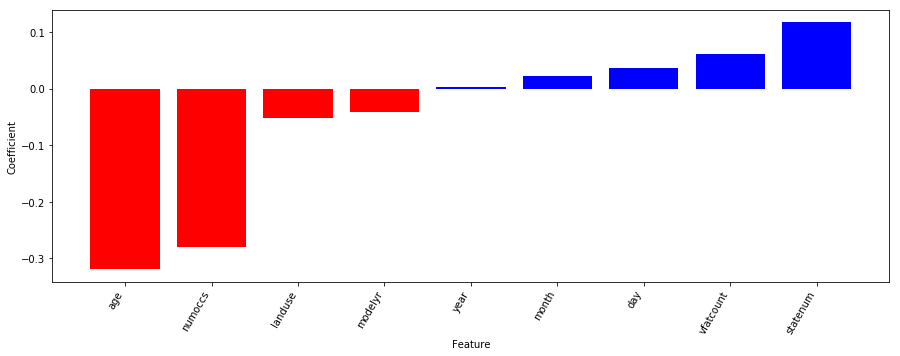

In [88]:
#Idea from:
'''A. Bakharia, “Visualising Top Features in Linear SVM with Scikit Learn and Matplotlib,” 
        Medium, 31-Jan-2016. [Online]. 
        Available: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d. 
        [Accessed: 29-Apr-2019].'''
coefs = linear_svc_classifier.coef_.ravel()
positive_coefs = np.argsort(coefs)[-4:]
negative_coefs = np.argsort(coefs)[:5]
coefficients = np.hstack([negative_coefs, positive_coefs])
feature_names = vectorizer.get_feature_names()

 # create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coefs[coefficients]]
plt.bar(np.arange(1 + 2 * 4), coefs[coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(0, 1 + 2 * 4), feature_names[coefficients], rotation=60, ha='right')
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.show()